# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from reproject import reproject_interp
from scipy.interpolate import interp1d
import copy

from minot.ClusterTools import map_tools
import pitszi

import macsj0717_libs as libs

sigma2fwhm = 2 * np.sqrt(2*np.log(2))

# Parameters

In [2]:
outdir = '/Users/adam/Project/Notes-Papier-Conf/2024_07_PITSZI_MACSJ0717/outputs/'

# Cluster parameters
cl_redshift = 0.546
cl_M500     = 20*1e14*u.Msun
cl_coord    = SkyCoord(109.3806*u.deg, 37.7583*u.deg, frame='icrs')

# Sampling
reso = 4*u.arcsec
FoV  = 4*u.arcmin
los_reso = 30*u.kpc
los_size = 8*u.Mpc

# Analysis parameters
ps_mask_lim = 0.1*100 # mJy
mask_theta = 2*u.arcmin
Nsim = 1000
apply_radial_model = True
clean_ksz = False

# Get the data

In [3]:
#===== Instrument parameters
beam_FWHM    = 18.2*u.arcsec
FoV_diameter = 2*u.arcmin
TF = libs.get_TF()

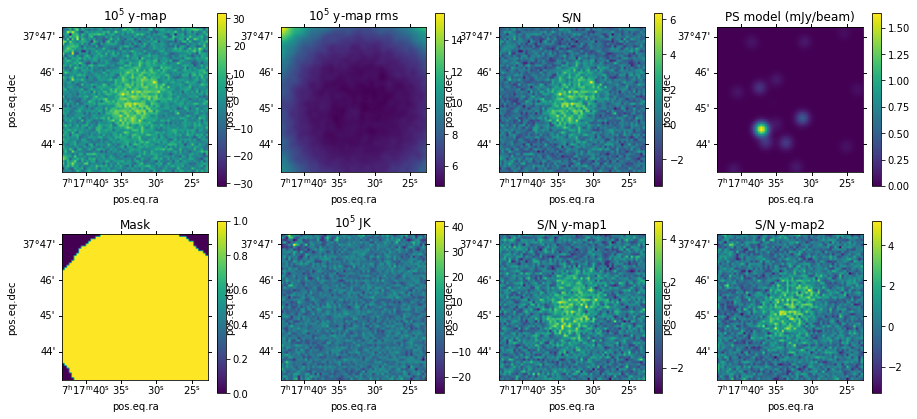

In [4]:
#===== Get the data
cl_head, y2jy, cl_img, cl_img1, cl_img2, cl_jk, cl_ps, cl_rms, cl_noise, cl_mask = libs.extract_data(FoV, reso, 
                                                                                                     ps_mask_lim,
                                                                                                     show=True,
                                                                                                     clean_ksz=clean_ksz)

# Define the model, data and inference

In [5]:
#========== cluster data
cl_data  = libs.def_data(cl_img,  cl_head, cl_noise, cl_mask, beam_FWHM, TF, outdir, Nsim)

In [6]:
#========== cluster model
cl_model = pitszi.Model(name='Model', RA=cl_coord.ra, Dec=cl_coord.dec, 
                        redshift=cl_redshift, M500=cl_M500, 
                        silent=True, output_dir=outdir)
cl_model.set_pressure_profile_universal_param('A10MD')
cl_model.map_header = cl_head
cl_model.los_reso  = los_reso
cl_model.los_size  = los_size
cl_model.R_truncation = 10*u.Mpc

In [7]:
#========== Inference radial
cl_Rinfer1 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=False, output_dir=outdir+'/RadialFit1/')
cl_Rinfer2 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=False, output_dir=outdir+'/RadialFit2/')
cl_Rinfer3 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=False, output_dir=outdir+'/RadialFit3/')
cl_Rinfer4 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=False, output_dir=outdir+'/RadialFit4/')
cl_Rinfer5 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=False, output_dir=outdir+'/RadialFit5/')

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                    Radial Inference                        
------------------------------------------------------------
                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                    Radi

# Fit the smooth model to the data

In [8]:
#========== Curvefit the profile case 1
fitpar_prof = libs.def_fitparprof(3)
plist, popt, pcov = cl_Rinfer1.run_curvefit_profile(fitpar_prof, 
                                                    show_fit_result=True, 
                                                    set_bestfit=True)

param 0 (M500): 
   median   = 26.474820498950447 -0.885389721921694 +0.9059803362270991
   best-fit = 26.510276169511528 -0.9208453924827751 +0.8705246656660179
   M500 = 26.474820498950447_{-0.885389721921694}^{0.9059803362270991}
param 1 (RA): 
   median   = 109.38687379709276 -0.0003637529084983271 +0.0003602525884076613
   best-fit = 109.38657663538547 -6.659120120389161e-05 +0.0006574142957020968
   RA = 109.38687379709276_{-0.0003637529084983271}^{0.0003602525884076613}
param 2 (Dec): 
   median   = 37.75300664963053 -0.000359222495468714 +0.0003419072658985556
   best-fit = 37.75314453259927 -0.000497105464212666 +0.00020402429715460357
   Dec = 37.75300664963053_{-0.000359222495468714}^{0.0003419072658985556}
param 3 (min_to_maj_axis_ratio): 
   median   = 0.7817664957748729 -0.026556475238044275 +0.02684499824275255
   best-fit = 0.7576225869974476 -0.0024125664606189368 +0.05098890702017789
   min_to_maj_axis_ratio = 0.7817664957748729_{-0.026556475238044275}^{0.026844998242

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [9]:
#========== Curvefit the profile case 2
fitpar_prof = libs.def_fitparprof(1)
plist, popt, pcov = cl_Rinfer2.run_curvefit_profile(fitpar_prof, 
                                                    show_fit_result=True, 
                                                    set_bestfit=True)

param 0 (M500): 
   median   = 18.142938761888352 -0.48981470824239537 +0.4919988349340976
   best-fit = 18.14980007838597 -0.4966760247400117 +0.48513751843648123
   M500 = 18.142938761888352_{-0.48981470824239537}^{0.4919988349340976}
param 1 (ZL): 
   median   = 1.8292193894979764e-05 -1.0064993009882808e-06 +9.887546276507538e-07
   best-fit = 1.8836435783991606e-05 -1.5507411900001228e-06 +4.4451273863891185e-07
   ZL = 1.8292193894979764e-05_{-1.0064993009882808e-06}^{9.887546276507538e-07}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [10]:
#========== Curvefit the profile case 3
fitpar_prof = libs.def_fitparprof(2)
plist, popt, pcov = cl_Rinfer3.run_curvefit_profile(fitpar_prof, 
                                                    show_fit_result=True, 
                                                    set_bestfit=True)

param 0 (M500): 
   median   = 21.6731118247739 -0.5409981918735056 +0.5120676447000179
   best-fit = 21.664061179231645 -0.5319475463312493 +0.5211182902422742
   M500 = 21.6731118247739_{-0.5409981918735056}^{0.5120676447000179}
param 1 (RA): 
   median   = 109.38704557653998 -0.00039096390888460064 +0.00039535457943884467
   best-fit = 109.38726884469042 -0.0006142320593340855 +0.00017208642898935977
   RA = 109.38704557653998_{-0.00039096390888460064}^{0.00039535457943884467}
param 2 (Dec): 
   median   = 37.75298424462237 -0.000315393280857279 +0.0003152582099730239
   best-fit = 37.75279290590294 -0.0001240545614322741 +0.0005065969293980288
   Dec = 37.75298424462237_{-0.000315393280857279}^{0.0003152582099730239}
param 3 (ZL): 
   median   = 1.586825522097385e-05 -9.887246543915073e-07 +9.895158424388428e-07
   best-fit = 1.610436193760704e-05 -1.224831371024697e-06 +7.534091258056531e-07
   ZL = 1.586825522097385e-05_{-9.887246543915073e-07}^{9.895158424388428e-07}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [11]:
#========== Curvefit the profile
fitpar_prof = libs.def_fitparprof(4)
plist, popt, pcov = cl_Rinfer4.run_curvefit_profile(fitpar_prof, 
                                                    show_fit_result=True, 
                                                    set_bestfit=True)

param 0 (P_0): 
   median   = 0.11668778194786458 -0.007874213538383357 +0.007750648136610375
   best-fit = 0.11224470885228383 -0.0034311404428025993 +0.012193721232191132
   P_0 = 0.11668778194786458_{-0.007874213538383357}^{0.007750648136610375}
param 1 (r_p): 
   median   = 853.5048960580912 -43.27250939341707 +43.937955577857565
   best-fit = 852.9672037206811 -42.734817056007046 +44.47564791526759
   r_p = 853.5048960580912_{-43.27250939341707}^{43.937955577857565}
param 2 (RA): 
   median   = 109.38731220838145 -0.00028601068784439576 +0.0002725506483471918
   best-fit = 109.38736490342038 -0.0003387057267758564 +0.00021985560941573112
   RA = 109.38731220838145_{-0.00028601068784439576}^{0.0002725506483471918}
param 3 (Dec): 
   median   = 37.75291996171505 -0.0002774382139207887 +0.0002773566133882355
   best-fit = 37.75286026239919 -0.00021773889805842828 +0.0003370559292505959
   Dec = 37.75291996171505_{-0.0002774382139207887}^{0.0002773566133882355}
param 4 (min_to_maj_axi

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [12]:
#========== Curvefit the profile
fitpar_prof = libs.def_fitparprof(5)
plist, popt, pcov = cl_Rinfer5.run_curvefit_profile(fitpar_prof, 
                                                    show_fit_result=True, 
                                                    set_bestfit=True)

param 0 (P_0): 
   median   = 0.10134553590397918 -0.012269167839062178 +0.009412301796984074
   best-fit = 0.0859202990333385 --0.003156069031578501 +0.024837538667624753
   P_0 = 0.10134553590397918_{-0.012269167839062178}^{0.009412301796984074}
param 1 (r_p): 
   median   = 427.16834716075493 -35.60162413154626 +28.373628457097936
   best-fit = 463.46793000627406 -71.90120697706539 +-7.925954388421189
   r_p = 427.16834716075493_{-35.60162413154626}^{28.373628457097936}
param 2 (a): 
   median   = 8.58707073873158 -1.4216077642603988 +0.9770793278156624
   best-fit = 8.225733172037927 -1.0602701975667461 +1.3384168945093151
   a = 8.58707073873158_{-1.4216077642603988}^{0.9770793278156624}
param 3 (b): 
   median   = 6.117917984419925 -1.8357268523747736 +1.3044897660840764
   best-fit = 6.502301157462866 -2.220110025417714 +0.9201065930411358
   b = 6.117917984419925_{-1.8357268523747736}^{1.3044897660840764}
param 4 (c): 
   median   = 0.12067938171806215 -0.08419046624776899 +0.1

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


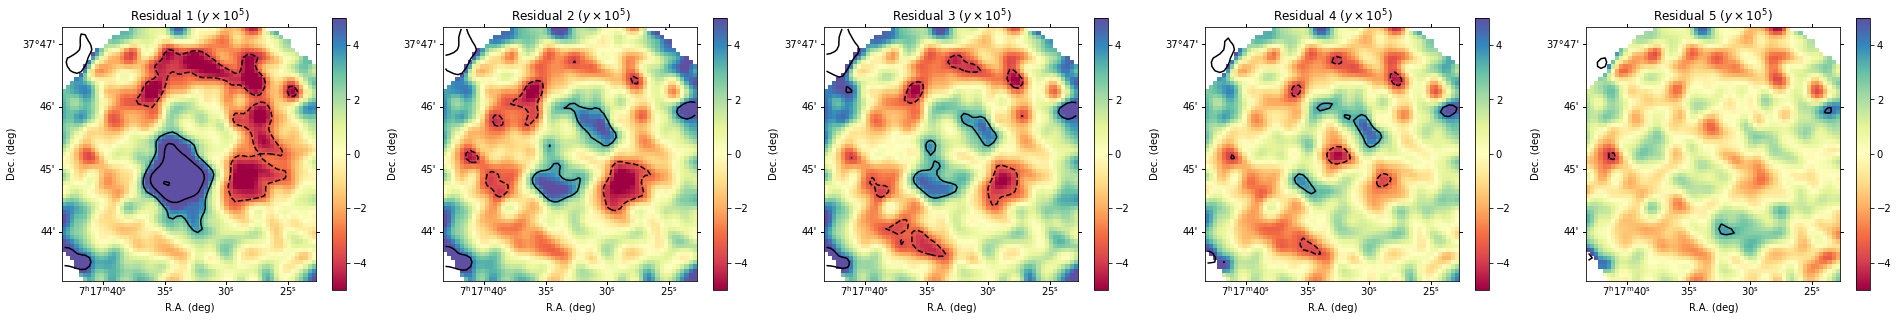

In [13]:
#===== Show the images

smooth_FWHM = 15*u.arcsec

# Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(33, 5))
model_sph1 = cl_Rinfer1.get_radial_model()
model_sph2 = cl_Rinfer2.get_radial_model()
model_sph3 = cl_Rinfer3.get_radial_model()
model_sph4 = cl_Rinfer4.get_radial_model()
model_sph5 = cl_Rinfer5.get_radial_model()
    
rms = cl_data.get_noise_rms_from_model(Nmc=Nsim, smooth_fwhm=smooth_FWHM)
rms = gaussian_filter(rms, sigma=10/3600/sigma2fwhm/cl_head['CDELT2'])
    
rng = [-5,5]

msk = copy.deepcopy(cl_data.mask)
msk[cl_data.mask == 0] = np.nan
    
#----- Residual 1
ax = plt.subplot(1, 5, 1, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img - model_sph2, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img - model_sph2, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title(r'Residual 1 ($y \times 10^5$)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
    
#----- Cluster model
ax = plt.subplot(1, 5, 2, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img - model_sph3, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img - model_sph3, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title(r'Residual 2 ($y \times 10^5$)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Residual model
ax = plt.subplot(1, 5, 3, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img - model_sph1, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img - model_sph1, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title(r'Residual 3 ($y \times 10^5$)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Residual model
ax = plt.subplot(1, 5, 4, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img - model_sph4, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img - model_sph4, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title(r'Residual 4 ($y \times 10^5$)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Residual model
ax = plt.subplot(1, 5, 5, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img - model_sph5, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img - model_sph5, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title(r'Residual 5 ($y \times 10^5$)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

plt.savefig(outdir+'/RadialFit_residuals.pdf')